---

# Possible decline of the urban forest in San Jose, California as seen through change in vegetation greenness
<img src="https://upload.wikimedia.org/wikipedia/commons/6/6f/Hazy_San_Jose_%2842987234361%29.jpg" alt="San Jose, California skyline with urban forest in the foreground" width="800"/>

> Image source: Ben Loomis, CC BY 2.0, [via Wikimedia Commons.](https://commons.wikimedia.org/wiki/File:Hazy_San_Jose_(42987234361).jpg)

In [1]:
# pip install geoviews

In [2]:
# pip install git+https://github.com/earthlab/earthpy@apppears

In [2]:
import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

import earthpy.appeears as etapp
import folium
import geopandas as gpd
import geoviews as gv
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import warnings
import xarray as xr

# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.filterwarnings('ignore')


In [4]:
# Generating the path to the project directory
project_dir = os.path.join(
    pathlib.Path.home(), "earth-analytics", "data", "camp-fire"
)

# Create the project directory
os.makedirs(project_dir, exist_ok=True)
project_dir

'/home/jovyan/earth-analytics/data/camp-fire'

### Map of city limits

In [6]:
# Pull shapefile from City of San Jose Open GIS portal
sanjose_gdf = gpd.read_file(
    "https://geo.sanjoseca.gov/server/rest/services/"
    "OPN/OPN_OpenDataService/MapServer/372/"
    "query?outFields=*&where=1%3D1&f=geojson")

sanjose_gdf

,OBJECTID,FACILITYID,INTID,INCORPORATED,INCORPAREA,LASTUPDATE,NOTES,SHAPE_Length,SHAPE_Area,geometry
0,1,1,1,San Jose,180.75,1688752509000,,1.429474e+06,5.039148e+09,"MULTIPOLYGON (((-121.78237 37.26501, -121.7823..."


>**Data Citation**
>
>City Limits. (n.d.). City of San Jose, California Open GIS Portal. Retrieved October 3, 2023, from https://gisdata-csj.opendata.arcgis.com/datasets/city-limits/explore?location=37.301433,-121.823480,11.00


In [7]:
# Plot San Jose city limits

sanjose_lat = 37.336111
sanjose_lon = -121.890556

# Create a folium map object
m = folium.Map(
    location = [sanjose_lat, sanjose_lon],
    zoom_start=11,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri World Imagery',
    #width = 800,
    #height = 800,
    scrollWheelZoom=False)

# Convert the GeoDataFrame to GEOJSON format
sanjose_geojson = sanjose_gdf.to_json()

# Add the GeoJSON data to the map as a GeoJson layer
sanjose_style = {
    "fillColor": "none",
    "color": "black",
    "weight": 3
}

folium.GeoJson(sanjose_geojson,
    style_function=lambda feature: sanjose_style
).add_to(m)

# Display the map
m

I downloaded NDVI data from NASA Appeears for the city of San Jose city limit. I only used data from the month of August, when the wild grasses growing in open spaces within the city are senesced, to capture changes in greenness in primarily human-planted and managed vegetation.

In [8]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key="modis-ndvi",
    ea_dir=project_dir,
    product="MYD13Q1.061",  # from list of APPEEARS datasts
    layer="_250m_16_days_NDVI",
    start_date="08-01",
    end_date="08-31",
    recurring=True,
    year_range=[2012, 2022],
    polygon=sanjose_gdf,
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

ndvi_downloader

In [10]:
# Generate list of data files
ndvi_path_list = glob(
    os.path.join(ndvi_downloader.data_dir, "*", "*NDVI*.tif")
)

ndvi_path_list

['/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2014233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2020201_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2013233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2016201_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2015217_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2021233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2022201_aid000

In [12]:
# Combine data into a single Data Array 
doy_start = -19
doy_end = -12
scale_factor = 10000

ndvi_da_list = []
for ndvi_path in ndvi_path_list:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor

    # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)

ndvi_da_list

[<xarray.DataArray 'NDVI' (date: 1, y: 168, x: 222)>
 array([[[   nan,    nan,    nan, ..., 0.3468, 0.3443, 0.3443],
         [   nan,    nan,    nan, ..., 0.4024, 0.4024, 0.4006],
         [   nan,    nan,    nan, ..., 0.3663, 0.3666, 0.3785],
         ...,
         [0.8165, 0.8521, 0.8468, ..., 0.3671, 0.3502, 0.3502],
         [0.84  , 0.8238, 0.8238, ..., 0.2364, 0.3018, 0.3112],
         [0.7611, 0.7611, 0.7576, ..., 0.4389, 0.3657, 0.3112]]],
       dtype=float32)
 Coordinates:
     band         int64 1
   * x            (x) float64 -122.0 -122.0 -122.0 ... -121.6 -121.6 -121.6
   * y            (y) float64 37.47 37.47 37.47 37.46 ... 37.13 37.13 37.12 37.12
     spatial_ref  int64 0
   * date         (date) datetime64[ns] 2014-08-21,
 <xarray.DataArray 'NDVI' (date: 1, y: 168, x: 222)>
 array([[[   nan,    nan,    nan, ..., 0.3787, 0.3787, 0.3787],
         [   nan,    nan,    nan, ..., 0.4573, 0.4573, 0.3997],
         [   nan,    nan,    nan, ..., 0.4486, 0.444 , 0.4703],
    

In [13]:
# Stack arrays into time series
ndvi_ds = xr.combine_by_coords(ndvi_da_list, coords=["date"])
ndvi_ds

<xarray.Dataset>
Dimensions:      (x: 222, y: 168, date: 33)
Coordinates:
    band         int64 1
  * x            (x) float64 -122.0 -122.0 -122.0 ... -121.6 -121.6 -121.6
  * y            (y) float64 37.47 37.47 37.47 37.46 ... 37.13 37.13 37.12 37.12
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2012-07-19 2012-08-04 ... 2022-08-21
Data variables:
    NDVI         (date, y, x) float32 nan nan nan nan ... 0.4652 0.348 0.2779

NDVI [should take values between -1.0 and 1.0.](https://ipad.fas.usda.gov/cropexplorer/Definitions/spotveg.htm) Let's make sure that is the case here.

(array([  1000.,   1538.,  16312., 125741., 393000., 257370., 161454.,
        119786.,  94390.,  31379.]),
 array([-0.19939999, -0.08719999,  0.025     ,  0.1372    ,  0.24939999,
         0.36159998,  0.47379997,  0.58599997,  0.69819999,  0.81039995,
         0.92259997]),
 <BarContainer object of 10 artists>)

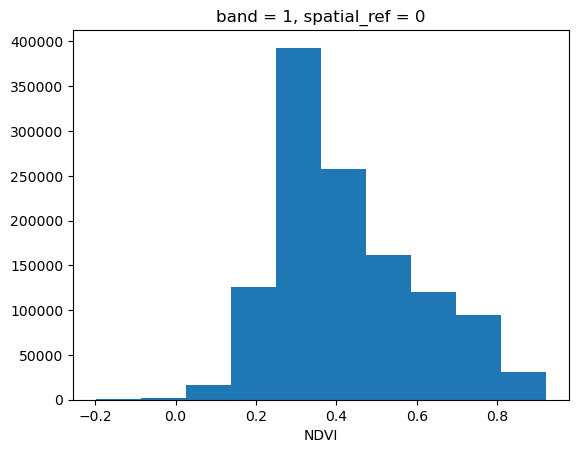

In [21]:
# Generate histogram of NDVI
import matplotlib.pyplot as plt

ndvi_ds.NDVI.plot()

A [city report](https://www.sanjoseca.gov/your-government/departments-offices/transportation/landscaping/trees/community-forest-management-plan) mentions that the urban forest canopy cover in San Jose has declined by 1.82% from 2012 to 2018. Let's see if NDVI within the city limits changed from 2012 to 2022.

In [24]:
# Calculate the change in NDVI in 2012 and in 2022
dndvi_da = (ndvi_ds
    .sel(date = '2022')
    .mean('date')
    .NDVI
- ndvi_ds
    .sel(date = '2012')
    .mean('date')
    .NDVI
)

In [25]:
# Check coordinate reference system of both datasets before plotting
print(sanjose_gdf.crs)
print(dndvi_da.rio.crs)

EPSG:4326
EPSG:4326


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

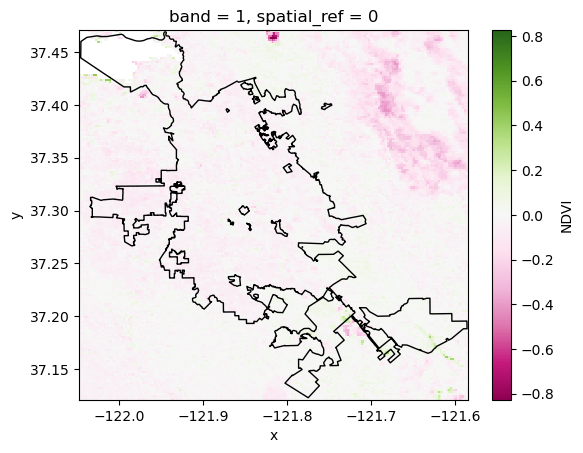

In [26]:
# Plot with matplotlib
dndvi_da.plot(cmap=plt.colormaps['PiYG'])
sanjose_gdf.plot(facecolor='none', ax=plt.gca())

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
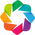

:Overlay
   .Image.I    :Image   [x,y]   (NDVI)
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [x,y]

In [28]:
# Create plots for the dndvi raster and San Jose polygon

import panel as pn
import geoviews as gv
import xarray as xr
gv.extension("bokeh")
pn.extension()

# import bokeh.io
# bokeh.io.output_notebook()


dndvi_plot = dndvi_da.rio.reproject(rxr.crs.CRS.from_epsg(3857)).hvplot(x='x', y='y', cmap='PiYG', shared_axes=True)

sanjose_plot = sanjose_gdf.to_crs(3857).hvplot(fill_color = "none", line_color='black', alpha=0.5, line_width = 2, shared_axes=True)

final_plot = dndvi_plot * gv.tile_sources.EsriImagery * sanjose_plot

# Display plot with San Jose boundary overlaid on NDVI
final_plot.opts(width=800, height=600)

In [30]:
slider = pn.widgets.FloatSlider(name="alpha", start=0, end=1, value=0.5)
slider.jslink(dndvi_plot, value="glyph.global_alpha")
pn.Column(slider, (dndvi_plot * gv.tile_sources.EsriImagery * sanjose_plot).opts(width=800, height=600)).servable()


BokehModel(combine_events=True, render_bundle={'docs_json': {'38f89e60-36a5-4fed-8a15-f504ae987908': {'version…

# Did the NDVI drop more inside the city limits than nearby areas?

In [32]:
# Get the area outside the city boundary
out_gdf = gpd.GeoDataFrame(geometry=sanjose_gdf.envelope).overlay(
    sanjose_gdf, how="difference"
)
out_gdf

,geometry
0,"MULTIPOLYGON (((-122.04607 37.12272, -122.0460..."


In [33]:
# Clip to get NDVI inside and outside the city boundary for our study area
ndvi_sanjose_ds = ndvi_ds.rio.clip(sanjose_gdf.geometry)
ndvi_outside_ds = ndvi_ds.rio.clip(out_gdf.geometry)

In [34]:
# Calculate the mean NDVI per year
ndvi_sanjose_df = (
    ndvi_sanjose_ds
    .groupby(ndvi_sanjose_ds.date.dt.year)
    .mean(...)
    # ... means take the mean by every variable
    # that is not a grouping variable
    .NDVI
    .to_dataframe()[["NDVI"]])
ndvi_outside_df = (
    ndvi_outside_ds
    .groupby(ndvi_outside_ds.date.dt.year)
    .mean(...)
    # ... means take the mean by every variable
    # that is not a grouping variable
    .NDVI
    .to_dataframe()[["NDVI"]])
ndvi_sanjose_df, ndvi_outside_df


(          NDVI
 year          
 2012  0.323291
 2013  0.330175
 2014  0.310622
 2015  0.306544
 2016  0.313752
 2017  0.319050
 2018  0.311588
 2019  0.330538
 2020  0.316916
 2021  0.304515
 2022  0.299192,
           NDVI
 year          
 2012  0.477988
 2013  0.480093
 2014  0.460221
 2015  0.472924
 2016  0.476541
 2017  0.474574
 2018  0.474207
 2019  0.503266
 2020  0.469537
 2021  0.440626
 2022  0.444641)

## How did August NDVI in San Jose change from 2012 to 2022?

In [35]:
# Create plot of NDVI within San Jose city limits
(ndvi_sanjose_df).hvplot(
    xlabel='year', ylabel='dNDVI',
    title='Change in NDVI inside the San Jose city limits from 2012-2022'
)

:Curve   [year]   (NDVI)

In [36]:
(ndvi_sanjose_df - ndvi_outside_df).hvplot(
    xlabel='year', ylabel='dNDVI',
    title='Difference in NDVI between inside and outside the San Jose city limits'
)

:Curve   [year]   (NDVI)

**The difference in NDVI between inside and outside city limits increased over time**

This could suggest that the urban greenness of San Jose is decling faster than surrounding cities. However, this analysis does not differentiate between adjacent city areas and adjacent areas of naturally existing forest, which are likely to exhibit different NDVI patterns. Therefore, it is not entirely possible to know from this analysis how the urban greenness of San Jose is changing over time compared to other nearby cities.

In [37]:
%%capture
%%bash
jupyter nbconvert sanjose_urbanforest.ipynb --to html --no-input --execute